In [1]:
from tensorflow.keras.models import Sequential
#import libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras_tuner.tuners import RandomSearch

2024-05-05 18:09:12.456577: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 18:09:12.466873: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 18:09:12.547236: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 18:09:13.466963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
img_height=224
img_width=224
batch_size=32
data_dir = '../data/animal_data'

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1944 files belonging to 15 classes.
Using 1556 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1944 files belonging to 15 classes.
Using 388 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']


2024-05-05 17:34:07.216374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


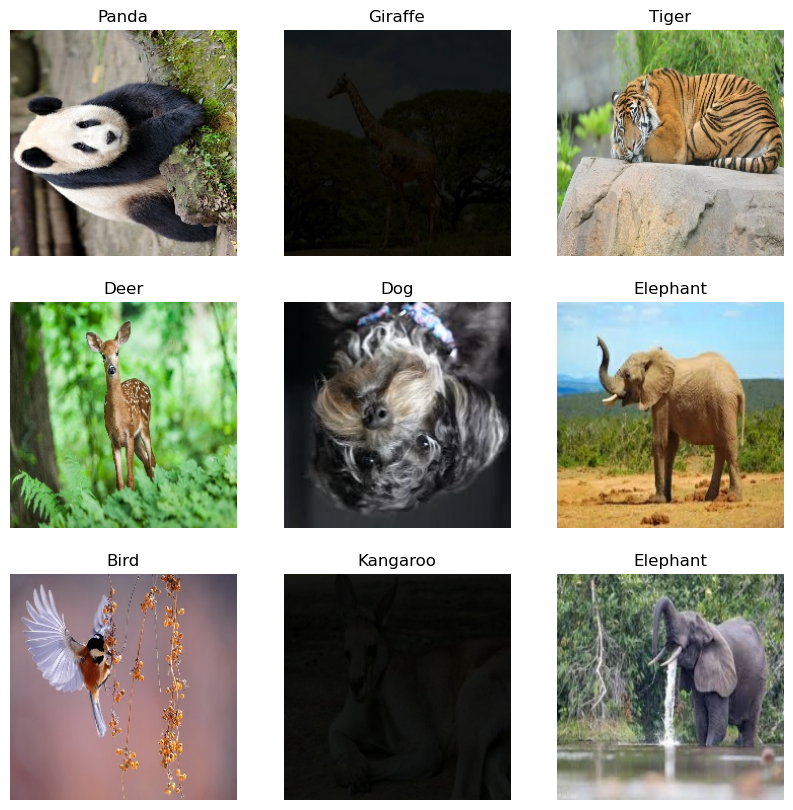

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

train_ds_norm = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds_norm = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
image_batch, labels_batch = next(iter(train_ds_norm))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [11]:
hyperparameters = {
    'l2_reg': [.1,.01,.001],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [1e-3, 5e-4, 1e-4]
}

In [15]:
def build_model(hp):
    model = Sequential([
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg', values=hyperparameters['l2_reg']))),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg', values=hyperparameters['l2_reg']))),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg', values=hyperparameters['l2_reg']))),
        layers.MaxPooling2D(),
        layers.Dropout(hp.Choice('dropout_rate', values=hyperparameters['dropout_rate'])),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(15)
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=hyperparameters['learning_rate'])),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model

In [16]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    project_name='animal_classificaion'
)

Reloading Tuner from ./animal_classificaion/tuner0.json


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(train_ds_norm, validation_data=val_ds_norm, epochs=10)
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
lr_scheduler = ReduceLROnPlateau(
    monitor="loss", factor=0.1, patience=5, mode="max", verbose=1
)

# Early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

save_callback=keras.callbacks.ModelCheckpoint(
    'best_model.keras', monitor="val_acc",save_best_only=True,mode='max',verbose=1
)

In [ ]:
best_model=build_model(best_hps)
history=best_model.fit(train_ds_norm,epochs=10,batch_size=batch_size,validation_data=val_ds_norm,verbose=2)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_url = "https://i.pinimg.com/originals/10/d7/75/10d775b05c5c4251f1ea02dab4cda35c.jpg"
test_path = tf.keras.utils.get_file('golden_retriever', origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = best_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)